# Final Project

In [3]:
import pandas as pd
import seaborn as sns


## Temperature

In [4]:
temperatures = pd.read_csv("data/temperature.csv")
temperatures['Date'] = pd.to_datetime(temperatures['Date'].astype(str), format='%Y%m') #.dt.to_period('M')
temperatures['Year'] = temperatures['Date'].dt.year
display(temperatures)

,Date,Value,Anomaly,Year
0,1895-01-01,26.69,-3.43,1895
1,1895-02-01,26.60,-7.22,1895
2,1895-03-01,39.97,-1.53,1895
3,1895-04-01,52.88,1.84,1895
4,1895-05-01,59.92,-0.27,1895
...,...,...,...,...
1553,2024-06-01,71.78,3.31,2024
1554,2024-07-01,75.69,2.10,2024
1555,2024-08-01,73.98,1.90,2024
1556,2024-09-01,68.59,3.75,2024


In [5]:
avg_temp = temperatures.groupby(['Year']).agg({'Value':['mean']}).reset_index()
avg_temp.columns = ['Year', "AvgTemp"]
display(avg_temp)

,Year,AvgTemp
0,1895,50.325833
1,1896,51.980000
2,1897,51.544167
3,1898,51.420833
4,1899,50.994167
...,...,...
125,2020,54.357500
126,2021,54.497500
127,2022,53.379167
128,2023,54.365833


<Axes: xlabel='Anomaly', ylabel='Value'>

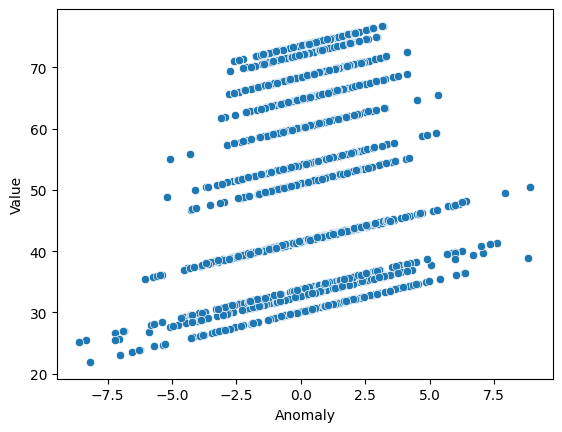

In [6]:
temp_scatter = sns.scatterplot(data = temperatures, x="Anomaly", y="Value")
display(temp_scatter)

<Axes: xlabel='Year', ylabel='AvgTemp'>

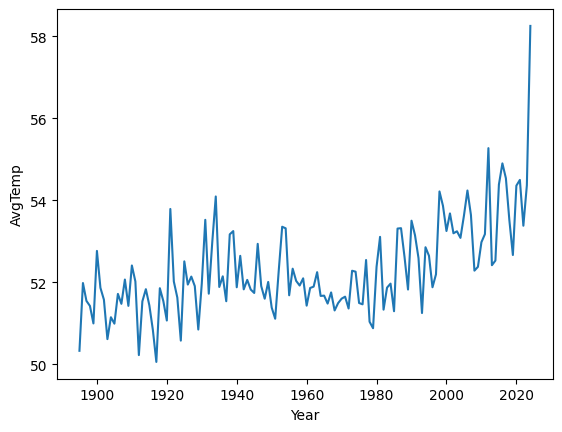

In [7]:
temp_timeseries = sns.lineplot(data=avg_temp, x='Year', y='AvgTemp')
display(temp_timeseries)

## Wildfires

In [8]:
wildfires = pd.read_csv("data/wildfire.csv")
wildfires['Date'] = pd.to_datetime(wildfires['Date'].astype(str), format='%Y%m')#.dt.to_period('M')
display(wildfires)

,Date,Acres Burned,Number of Fires,Acres Burned per Fire
0,2000-01-01,40757,2796,14.58
1,2000-02-01,168210,5671,29.66
2,2000-03-01,340899,10312,33.06
3,2000-04-01,182713,9236,19.78
4,2000-05-01,294493,11850,24.85
...,...,...,...,...
293,2024-06-01,421828,3472,121.49
294,2024-07-01,2018399,6943,290.71
295,2024-08-01,1887352,5477,344.60
296,2024-09-01,1579679,5042,313.30


In [9]:
wildfires['Year'] = wildfires['Date'].dt.year
avg_fires = wildfires.groupby(['Year']).agg({'Acres Burned': ['sum']}).reset_index()
avg_fires.columns = ['Year', "Acres Burned"]
display(avg_fires)

,Year,Acres Burned
0,2000,7393493
1,2001,3570911
2,2002,7184712
3,2003,3960842
4,2004,8097880
5,2005,8689389
6,2006,9873745
7,2007,9328045
8,2008,5292468
9,2009,5921786


<Axes: xlabel='Year', ylabel='Acres Burned'>

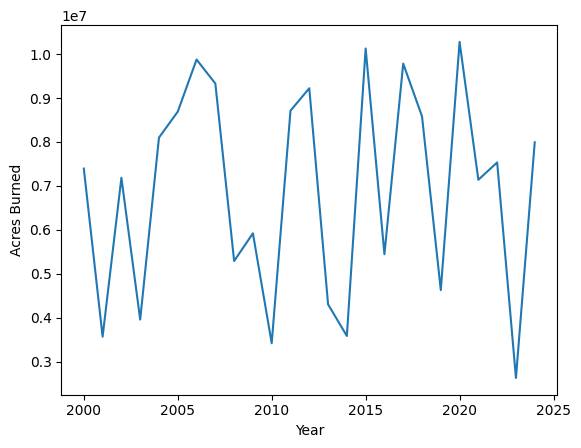

In [10]:
fires_timeseries = sns.lineplot(data=avg_fires, x='Year', y='Acres Burned')
display(fires_timeseries)

<Axes: xlabel='Number of Fires', ylabel='Acres Burned'>

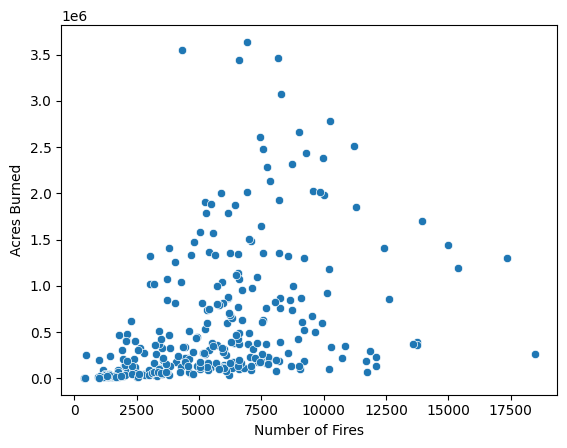

In [11]:
wildfire_scatter = sns.scatterplot(data=wildfires, x='Number of Fires', y='Acres Burned')
display(wildfire_scatter)

<Axes: xlabel='Number of Fires', ylabel='Acres Burned'>

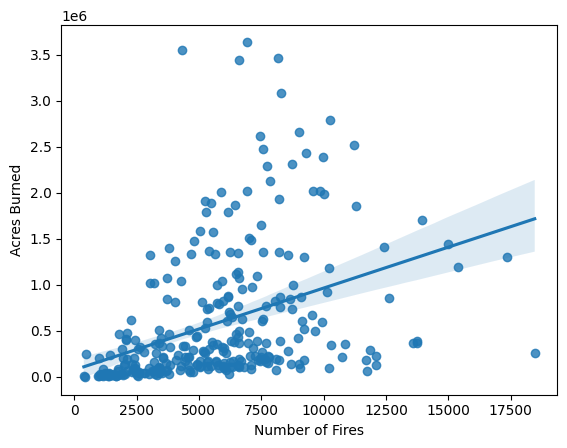

In [29]:
wildfire_scatter = sns.regplot(data=wildfires, x='Number of Fires', y='Acres Burned')
display(wildfire_scatter)

In [31]:
# create X and y
feature_cols = ['Number of Fires']
X = wildfires[feature_cols]
y = wildfires['Acres Burned']

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
print(lm.coef_)

74348.3583421539
[88.88499887]


<Axes: xlabel='Date', ylabel='Number of Fires'>

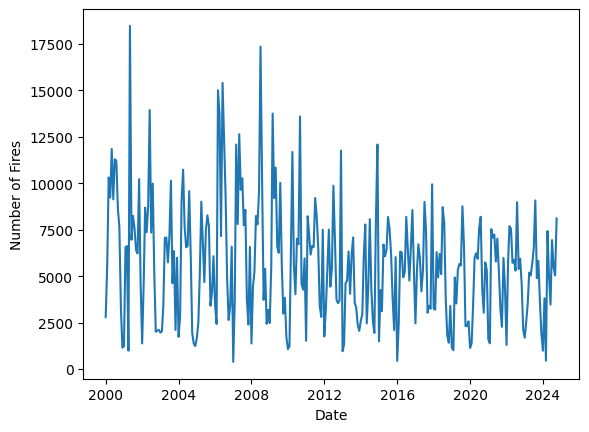

In [12]:
wildfire_lineplot_nof = sns.lineplot(data=wildfires, x='Date', y='Number of Fires')
display(wildfire_lineplot_nof)

<Axes: xlabel='Date', ylabel='Acres Burned'>

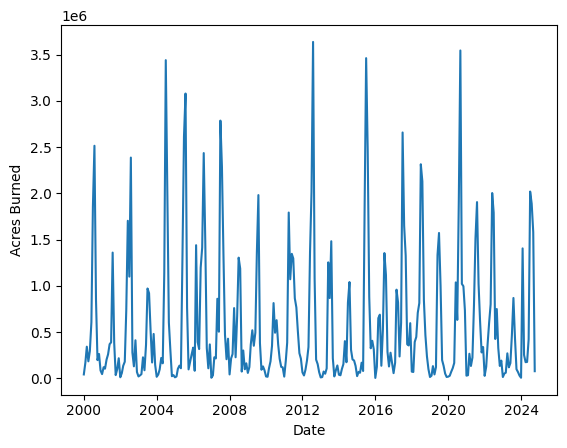

In [13]:
wildfire_lineplot_acres_burned = sns.lineplot(data=wildfires, x='Date', y='Acres Burned')
display(wildfire_lineplot_acres_burned)

## Precipitation

In [14]:
precipitation = pd.read_csv("data/precipitation.csv")
precipitation['Date'] = pd.to_datetime(precipitation['Date'].astype(str), format='%Y%m')#.dt.to_period('M')
precipitation['Year'] = precipitation['Date'].dt.year
display(precipitation)

,Date,Value,Anomaly,Year
0,1895-01-01,3.31,0.99,1895
1,1895-02-01,1.41,-0.72,1895
2,1895-03-01,1.99,-0.52,1895
3,1895-04-01,1.99,-0.52,1895
4,1895-05-01,2.88,-0.02,1895
...,...,...,...,...
1553,2024-06-01,2.76,-0.16,2024
1554,2024-07-01,3.08,0.29,2024
1555,2024-08-01,2.45,-0.16,2024
1556,2024-09-01,2.30,-0.16,2024


In [15]:
avg_prec = precipitation.groupby(['Year']).agg({'Value':['mean']}).reset_index()
avg_prec.columns = ['Year', "AvgPrec"]
display(avg_prec)

,Year,AvgPrec
0,1895,2.294167
1,1896,2.480833
2,1897,2.473333
3,1898,2.463333
4,1899,2.390833
...,...,...
125,2020,2.531667
126,2021,2.534167
127,2022,2.370833
128,2023,2.461667


<Axes: xlabel='Year', ylabel='AvgPrec'>

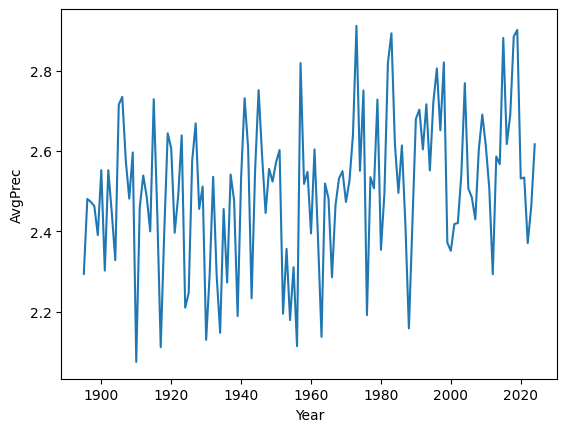

In [16]:
prec_timeseries = sns.lineplot(data=avg_prec, x='Year', y='AvgPrec')
display(prec_timeseries)

## Hurricanes

In [17]:
hurricane = pd.read_csv("data/hurricane.csv")
hurricane['Date'] = hurricane['year'].astype(str) + "-" + hurricane['month'].astype(str).str.zfill(2) + "-" + hurricane['day'].astype(str).str.zfill(2)
hurricane['Date'] = pd.to_datetime(hurricane['Date'], format="%Y-%m-%d").dt.to_period('M')
display(hurricane)

,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter,Date
0,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
1,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
2,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
3,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
4,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN,1975-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19061,Wanda,2021,11,7,0,37.4,-37.4,tropical storm,NaN,35,1003,60.0,0.0,2021-11
19062,Wanda,2021,11,7,6,38.1,-36.4,tropical storm,NaN,35,1004,60.0,0.0,2021-11
19063,Wanda,2021,11,7,12,39.2,-34.9,other low,NaN,35,1006,90.0,0.0,2021-11
19064,Wanda,2021,11,7,18,40.9,-32.8,other low,NaN,40,1006,90.0,0.0,2021-11


<Axes: xlabel='wind', ylabel='pressure'>

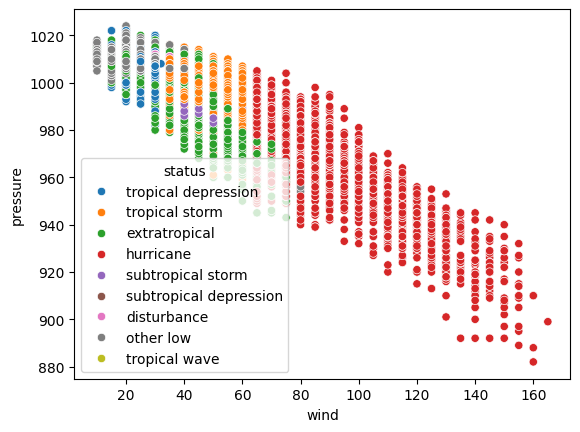

In [18]:
hurricane_scatter_status = sns.scatterplot(data=hurricane, x='wind', y='pressure', hue='status')
display(hurricane_scatter_status)

<Axes: xlabel='wind', ylabel='pressure'>

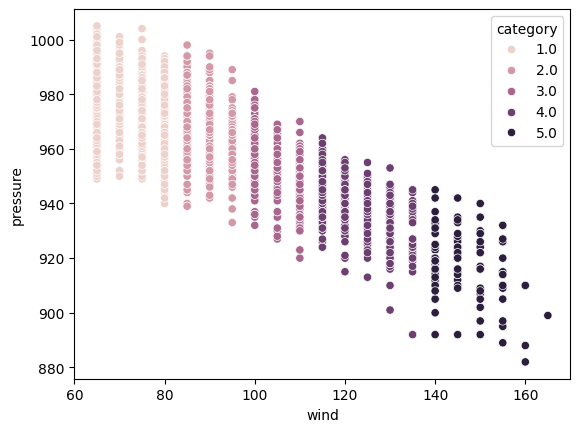

In [19]:
hurricane_scatter_category = sns.scatterplot(data=hurricane, x='wind', y='pressure', hue='category')
display(hurricane_scatter_category) # This doesn't take into account the NA's

## Tornadoes

In [20]:
tornadoes = pd.read_csv("data/tornado.csv")
tornadoes['Date'] = pd.to_datetime(tornadoes['Date'].astype(str), format='%Y%m').dt.to_period('M')
tornadoes['Tornadoes'] = tornadoes['Tornadoes'].str.replace('*', '')
tornadoes['Tornadoes'] = pd.to_numeric(tornadoes['Tornadoes'])
tornadoes['Fatalities'] = pd.to_numeric(tornadoes['Fatalities'])
tornadoes['Year'] = tornadoes['Date'].dt.year

display(tornadoes)

avg_tornadoes = tornadoes.groupby(['Year']).agg({'Tornadoes': ['sum']}).reset_index()
avg_tornadoes.columns = ['Year', "Tornadoes"]
display(avg_tornadoes)


C:\Users\layto\AppData\Local\Temp\ipykernel_10708\2237382403.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tornadoes['Tornadoes'] = tornadoes['Tornadoes'].str.replace('*', '')


,Date,Tornadoes,Fatalities,Year
0,1950-01,7,1,1950
1,1950-02,20,45,1950
2,1950-03,21,1,1950
3,1950-04,15,12,1950
4,1950-05,61,2,1950
...,...,...,...,...
893,2024-06,166,1,2024
894,2024-07,221,2,2024
895,2024-08,91,1,2024
896,2024-09,73,2,2024


,Year,Tornadoes
0,1950,201
1,1951,260
2,1952,240
3,1953,422
4,1954,550
...,...,...
70,2020,1082
71,2021,1314
72,2022,1143
73,2023,1321


<Axes: xlabel='Year', ylabel='Tornadoes'>

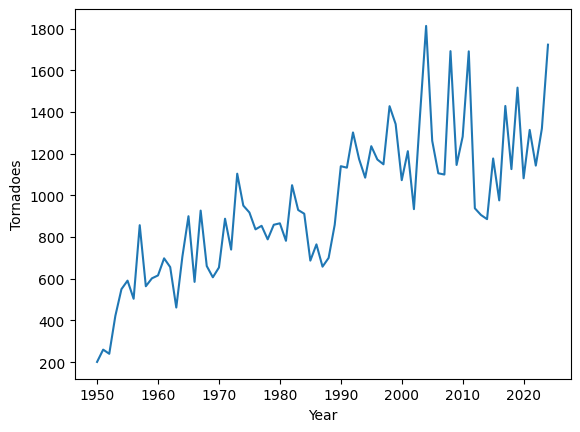

In [21]:
tornadoes_timeseries = sns.lineplot(data=avg_tornadoes, x='Year', y='Tornadoes')
display(tornadoes_timeseries)

<Axes: xlabel='Tornadoes', ylabel='Fatalities'>

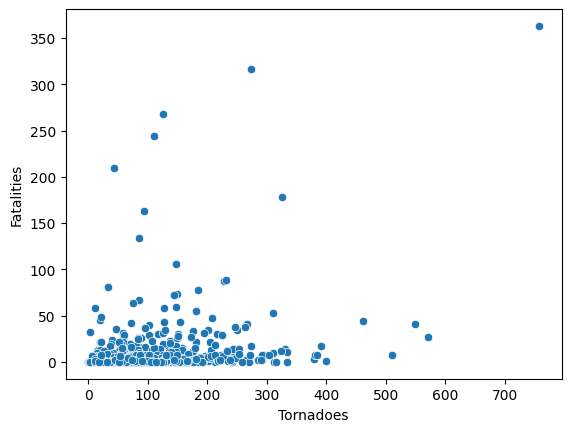

In [22]:
tornadoes_scatter = sns.scatterplot(data=tornadoes, x='Tornadoes', y='Fatalities')
display(tornadoes_scatter) 

In [23]:
new_tornadoes = pd.read_csv("data/1950-2023_actual_tornadoes.csv")
new_tornadoes['Date'] = pd.to_datetime(new_tornadoes['date'], format="%Y-%m-%d").dt.to_period('M')
display(new_tornadoes)

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,Date
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,10,1,1,1,25,0,0,0,0,1950-10
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,880,1,1,1,47,0,0,0,0,1950-10
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,10,1,1,1,177,0,0,0,0,1950-11
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,10,1,1,1,209,0,0,0,0,1950-11
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,37,1,1,1,101,0,0,0,0,1950-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70017,623328,2023,9,26,2023-09-26,15:05:00,3,FL,12,0,...,5,1,1,1,19,0,0,0,0,2023-09
70018,623329,2023,9,28,2023-09-28,13:40:00,3,OH,39,0,...,25,1,1,1,97,0,0,0,0,2023-09
70019,623330,2023,9,29,2023-09-29,18:48:00,3,MN,27,0,...,25,1,1,1,171,0,0,0,0,2023-09
70020,623304,2023,9,2,2023-09-02,10:11:00,3,LA,22,0,...,75,1,1,1,51,0,0,0,0,2023-09


<Axes: xlabel='wid', ylabel='stn'>

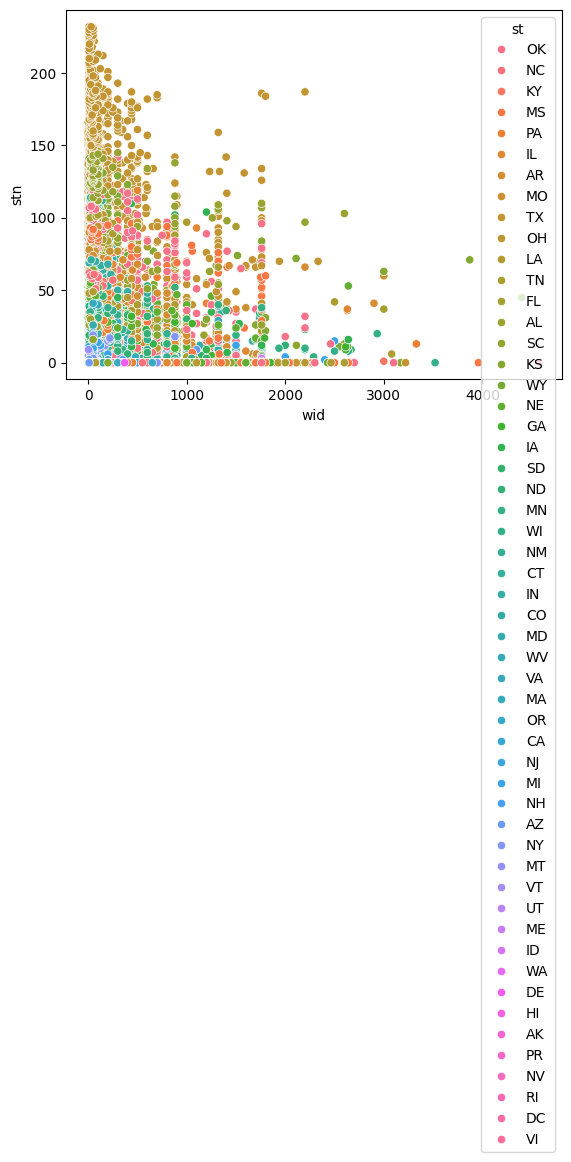

In [24]:
new_tornadoes_scatter_1 = sns.scatterplot(data=new_tornadoes, x='wid', y='stn', hue='st')
display(new_tornadoes_scatter_1) 

<Axes: xlabel='stf', ylabel='stn'>

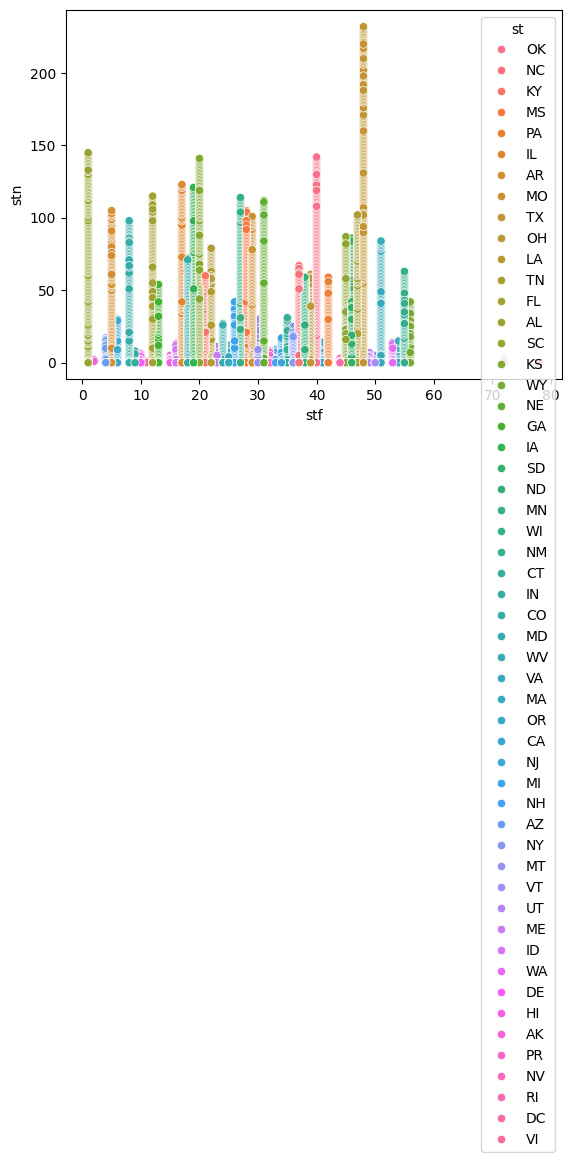

In [25]:
new_tornadoes_scatter_2 = sns.scatterplot(data=new_tornadoes, x='stf', y='stn', hue='st')
display(new_tornadoes_scatter_2) 

<Axes: xlabel='wid', ylabel='stf'>

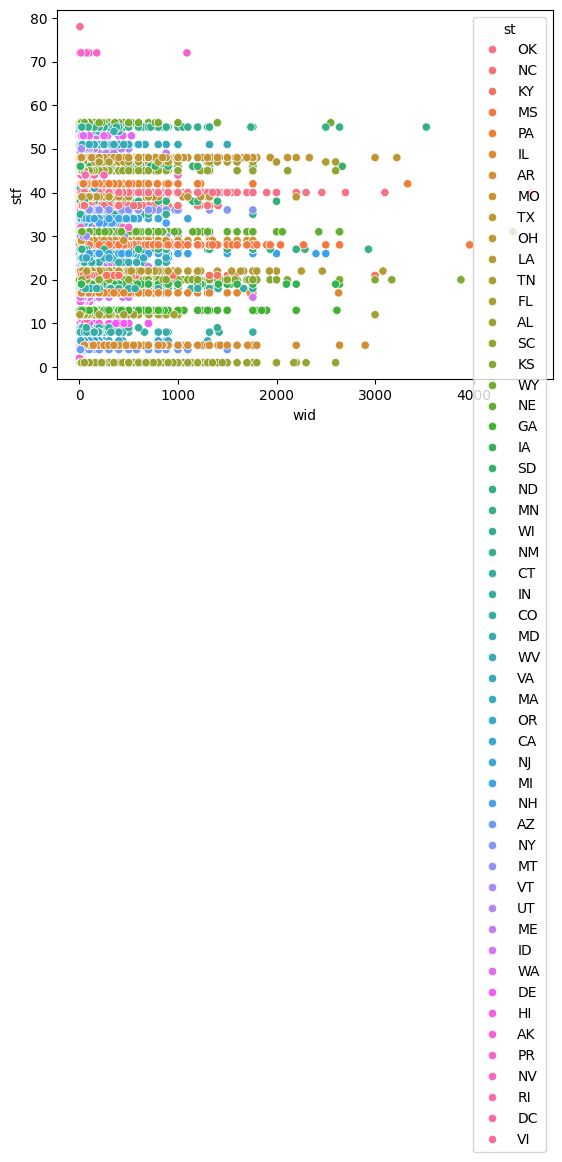

In [26]:
new_tornadoes_scatter_3 = sns.scatterplot(data=new_tornadoes, x='wid', y='stf', hue='st')
display(new_tornadoes_scatter_3) 

## earthquake

In [28]:
earthquake = pd.read_csv("data/eqint_tsqp.csv")
earthquake_usa = earthquake[(earthquake.COUNTRY == "USA") & (earthquake.LONGITUDE < 0)]
display(earthquake_usa)

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LOCAL_TO_UTC,UNPUB_OR_GROUPED_INT,LATITUDE,LONGITUDE,MAGNITUDE,EQ_DEPTH,EPIDIST,CITY_LAT,CITY_LON,MMI,STATE,CITY,SOURCE,COUNTRY
0,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.50,-119.00,NaN,NaN,0.0,34.50,-119.00,7.0,CA,LOCKWOOD VALLEY,H,USA
1,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.50,-119.00,NaN,NaN,258.0,33.02,-116.84,6.0,CA,SAN DIEGO,H,USA
2,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.50,-119.00,NaN,NaN,159.0,35.35,-120.41,6.0,CA,SAN LUIS OBISPO,H,USA
3,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.50,-119.00,NaN,NaN,NaN,NaN,NaN,6.0,CA,COLORADO RIVER,H,USA
4,1860,11.0,12.0,NaN,NaN,NaN,8.0,NaN,41.00,-124.00,NaN,NaN,32.0,40.76,-124.22,8.0,CA,HUMBOLDT BAY,H,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157001,1947,3.0,14.0,23.0,5.0,32.0,8.0,NaN,35.72,-118.08,NaN,NaN,20.0,35.67,-118.30,3.0,CA,WELDON,U,USA
157002,1947,3.0,15.0,5.0,15.0,NaN,8.0,NaN,35.72,-118.08,NaN,NaN,20.0,35.67,-118.30,3.0,CA,WELDON,U,USA
157008,1947,3.0,21.0,19.0,39.0,42.0,8.0,NaN,33.00,-115.51,NaN,NaN,0.0,33.00,-115.50,3.0,CA,BRAWLEY (NE SECTION),U,USA
157010,1947,3.0,27.0,9.0,16.0,46.0,8.0,NaN,35.00,-121.00,4.2,NaN,63.0,34.64,-120.46,4.0,CA,LOMPOC,U,USA


<Axes: xlabel='EPIDIST', ylabel='MMI'>

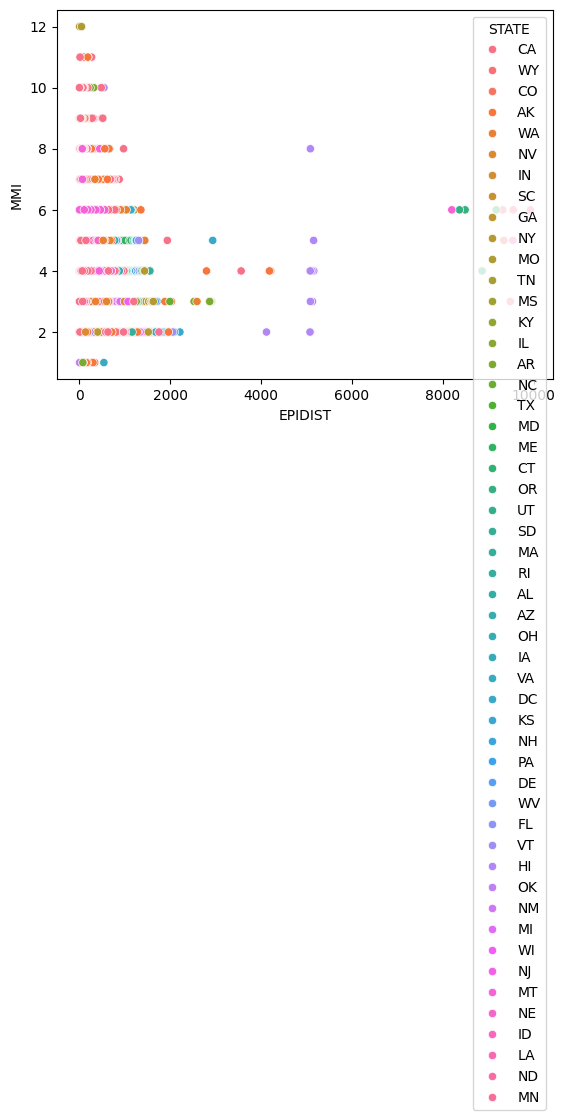

In [ ]:
new_earthquake_scatter_1 = sns.scatterplot(data=earthquake_usa, x='EPIDIST', y='MMI', hue='STATE')
display(new_earthquake_scatter_1) 

## temperatures affect on other elements

In [34]:
# Merge datasets sequentially, keeping only overlapping years
merged_data = avg_temp.merge(avg_prec, on='Year', how='inner') \
                       .merge(avg_fires, on='Year', how='inner') \
                       .merge(avg_tornadoes, on='Year', how='inner')

print(merged_data)


    Year    AvgTemp   AvgPrec  Acres Burned  Tornadoes
0   2000  53.250833  2.351667       7393493       1073
1   2001  53.680000  2.418333       3570911       1212
2   2002  53.195000  2.420833       7184712        934
3   2003  53.243333  2.540833       3960842       1385
4   2004  53.082500  2.769167       8097880       1813
5   2005  53.625000  2.506667       8689389       1262
6   2006  54.239167  2.485000       9873745       1106
7   2007  53.640833  2.430000       9328045       1100
8   2008  52.282500  2.603333       5292468       1692
9   2009  52.375833  2.690833       5921786       1146
10  2010  52.976667  2.613333       3422724       1282
11  2011  53.173333  2.507500       8711367       1691
12  2012  55.273333  2.293333       9221639        938
13  2013  52.415000  2.586667       4307176        906
14  2014  52.528333  2.567500       3587561        886
15  2015  54.382500  2.881667      10125149       1177
16  2016  54.901667  2.617500       5446520        976
17  2017  

In [35]:
# create X and y
feature_cols = ['AvgTemp']
X = merged_data[feature_cols]
y = merged_data['Acres Burned']

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
print(lm.coef_)

-31654694.461146746
[717403.57191676]


This means that an increase in one unit of AvgTemp had an increase of 717,404 acres burned

<Axes: xlabel='AvgTemp', ylabel='Acres Burned'>

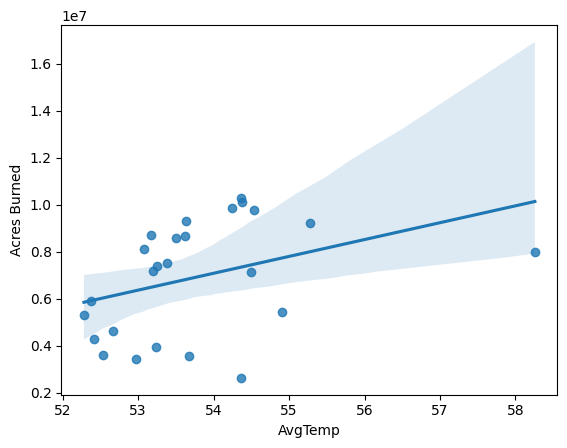

In [36]:
avgtemp_acresburned = sns.regplot(merged_data, x="AvgTemp", y="Acres Burned")
display(avgtemp_acresburned)

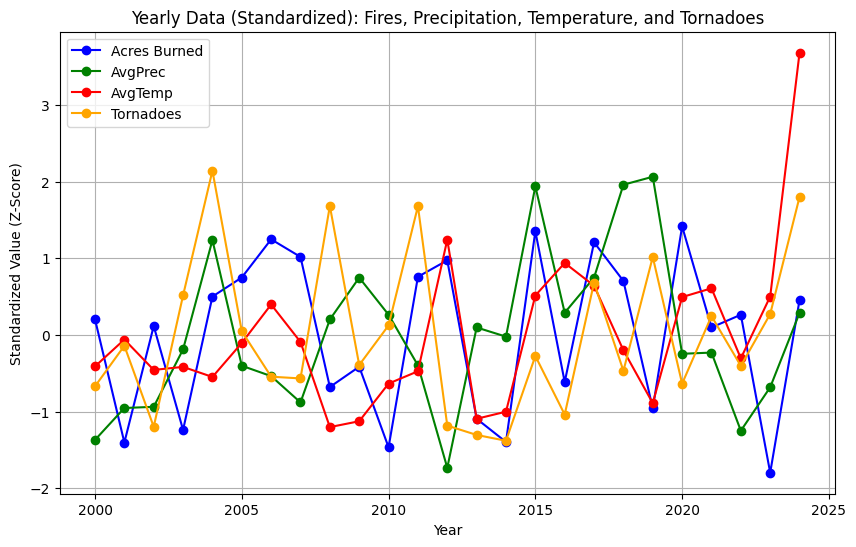

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create a copy of the merged_data
standardized_data = merged_data.copy()

# Apply Z-Score Standardization
scaler = StandardScaler()
standardized_data[['Acres Burned', 'AvgPrec', 'AvgTemp', 'Tornadoes']] = scaler.fit_transform(
    merged_data[['Acres Burned', 'AvgPrec', 'AvgTemp', 'Tornadoes']]
)

# Plot the standardized data
plt.figure(figsize=(10, 6))
plt.plot(standardized_data['Year'], standardized_data['Acres Burned'], label='Acres Burned', color='blue', marker='o')
plt.plot(standardized_data['Year'], standardized_data['AvgPrec'], label='AvgPrec', color='green', marker='o')
plt.plot(standardized_data['Year'], standardized_data['AvgTemp'], label='AvgTemp', color='red', marker='o')
plt.plot(standardized_data['Year'], standardized_data['Tornadoes'], label='Tornadoes', color='orange', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Standardized Value (Z-Score)')
plt.title('Yearly Data (Standardized): Fires, Precipitation, Temperature, and Tornadoes')
plt.legend()
plt.grid(True)
plt.show()


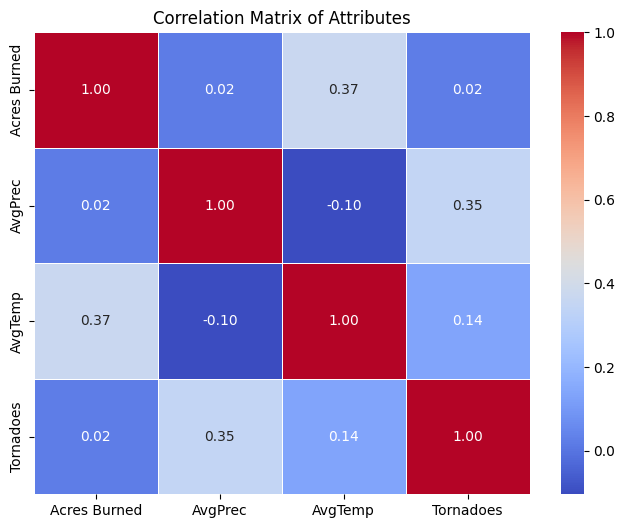

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the relevant columns
correlation_matrix = merged_data[['Acres Burned', 'AvgPrec', 'AvgTemp', 'Tornadoes']].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix of Attributes')
plt.show()


## billion dollar disasters (cost is in millions)

In [ ]:
costly_disasters = pd.read_csv("data/events-US-1980-2024-Q3.csv")
costly_cyclones = costly_disasters[costly_disasters['Disaster'] == "Tropical Cyclone"]

costly_cyclones['Begin Date'] = pd.to_datetime(costly_cyclones['Begin Date'], format="%Y%m%d")
costly_cyclones['End Date'] = pd.to_datetime(costly_cyclones['End Date'], format="%Y%m%d")
df_sorted = costly_cyclones.sort_values(by='Deaths', ascending=False)
deadliest_hurricanes = df_sorted.head(10)
deadliest_hurricanes['Name'] = deadliest_hurricanes['Name'].str.split().apply(lambda x: x[1] if len(x) > 1 else None)
deadliest_hurricanes

C:\Users\jobea\AppData\Local\Temp\ipykernel_14016\2868889090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costly_cyclones['Begin Date'] = pd.to_datetime(costly_cyclones['Begin Date'], format="%Y%m%d")
C:\Users\jobea\AppData\Local\Temp\ipykernel_14016\2868889090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costly_cyclones['End Date'] = pd.to_datetime(costly_cyclones['End Date'], format="%Y%m%d")
C:\Users\jobea\AppData\Local\Temp\ipykernel_14016\2868889090.py:8: SettingWithCopyWarning: 
A value 

,Name,Disaster,Begin Date,End Date,CPI-Adjusted Cost,Unadjusted Cost,Deaths
255,Maria,Tropical Cyclone,2017-09-19,2017-09-21,115200,90000,2981
119,Katrina,Tropical Cyclone,2005-08-25,2005-08-30,200047.3,125029.5,1833
398,Helene,Tropical Cyclone,2024-09-24,2024-09-29,TBD,TBD,225
190,Sandy,Tropical Cyclone,2012-10-30,2012-10-31,88453.9,65039.6,159
343,Ian,Tropical Cyclone,2022-09-28,2022-09-30,118508,111800,152
121,Rita,Tropical Cyclone,2005-09-20,2005-09-24,29230.2,18500.1,119
145,Ike,Tropical Cyclone,2008-09-12,2008-09-14,43198.4,29998.8,112
254,Irma,Tropical Cyclone,2017-09-06,2017-09-12,64000,50000,97
324,Ida,Tropical Cyclone,2021-08-29,2021-09-01,84608.1,73572,96
253,Harvey,Tropical Cyclone,2017-08-25,2017-08-31,160000,125000,89


In [ ]:
hurricane

,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter,Date
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
3,4,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN,1975-06
4,5,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN,1975-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19061,19062,Wanda,2021,11,7,0,37.4,-37.4,tropical storm,NaN,35,1003,60.0,0.0,2021-11
19062,19063,Wanda,2021,11,7,6,38.1,-36.4,tropical storm,NaN,35,1004,60.0,0.0,2021-11
19063,19064,Wanda,2021,11,7,12,39.2,-34.9,other low,NaN,35,1006,90.0,0.0,2021-11
19064,19065,Wanda,2021,11,7,18,40.9,-32.8,other low,NaN,40,1006,90.0,0.0,2021-11


In [ ]:
# deadliest_hurricanes['Year'] = deadliest_hurricanes['Year'].astype(int)
# hurricane['year'] = hurricane['year'].astype(int)
# print(deadliest_hurricanes['Year'].dtype)  # Should be int or str
# print(hurricane['year'].dtype)  # Should be int or str
# deadliest_hurricanes['Name'] = deadliest_hurricanes['Name'].str.strip().str.lower()
# hurricane['name'] = hurricane['name'].str.strip().str.lower()


In [ ]:
hurricane['name'] = hurricane['name'].str.strip()
# Extract the year from 'Begin Date' in the deadliest hurricanes dataset
deadliest_hurricanes['Year'] = deadliest_hurricanes['Begin Date'].astype(str).str[:4].astype(int)

# Merge the two datasets on 'Name' and 'Year'
matching_hurricanes = pd.merge(
    hurricane,
    deadliest_hurricanes,  # Select only Name and Year columns for matching
    left_on=['name', 'year'],
    right_on=['Name', 'Year'],
)

print(matching_hurricanes)

     Unnamed: 0     name  year  month  day  hour   lat  long  \
0         10384  Katrina  2005      8   23    18  23.1 -75.1   
1         10385  Katrina  2005      8   24     0  23.4 -75.7   
2         10386  Katrina  2005      8   24     6  23.8 -76.2   
3         10387  Katrina  2005      8   24    12  24.5 -76.5   
4         10388  Katrina  2005      8   24    18  25.4 -76.9   
..          ...      ...   ...    ...  ...   ...   ...   ...   
420       18735      Ida  2021      9    3    18  48.6 -62.4   
421       18736      Ida  2021      9    4     0  48.8 -63.1   
422       18737      Ida  2021      9    4     6  48.7 -63.9   
423       18738      Ida  2021      9    4    12  47.6 -63.9   
424       18739      Ida  2021      9    4    18  46.6 -63.5   

                  status  category  ...  hurricane_force_diameter     Date  \
0    tropical depression       NaN  ...                       0.0  2005-08   
1    tropical depression       NaN  ...                       0.0  2005-08 

C:\Users\jobea\AppData\Local\Temp\ipykernel_14016\1914044981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadliest_hurricanes['Year'] = deadliest_hurricanes['Begin Date'].astype(str).str[:4].astype(int)


# Maps

In [ ]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from geodatasets import get_path

In [ ]:
gdf = geopandas.GeoDataFrame(
    earthquake_usa, geometry=geopandas.points_from_xy(earthquake_usa.LONGITUDE, earthquake_usa.LATITUDE), crs="EPSG:4326"
)
print(gdf.head())

   YEAR  MONTH   DAY  HOUR  MINUTE  SECOND  LOCAL_TO_UTC UNPUB_OR_GROUPED_INT  \
0  1852   11.0  27.0   NaN     NaN     NaN           8.0                  NaN   
1  1852   11.0  27.0   NaN     NaN     NaN           8.0                  NaN   
2  1852   11.0  27.0   NaN     NaN     NaN           8.0                  NaN   
3  1852   11.0  27.0   NaN     NaN     NaN           8.0                  NaN   
4  1860   11.0  12.0   NaN     NaN     NaN           8.0                  NaN   

   LATITUDE  LONGITUDE  ...  EQ_DEPTH  EPIDIST  CITY_LAT  CITY_LON  MMI  \
0      34.5     -119.0  ...       NaN      0.0     34.50   -119.00  7.0   
1      34.5     -119.0  ...       NaN    258.0     33.02   -116.84  6.0   
2      34.5     -119.0  ...       NaN    159.0     35.35   -120.41  6.0   
3      34.5     -119.0  ...       NaN      NaN       NaN       NaN  6.0   
4      41.0     -124.0  ...       NaN     32.0     40.76   -124.22  8.0   

   STATE             CITY SOURCE COUNTRY           geometry  


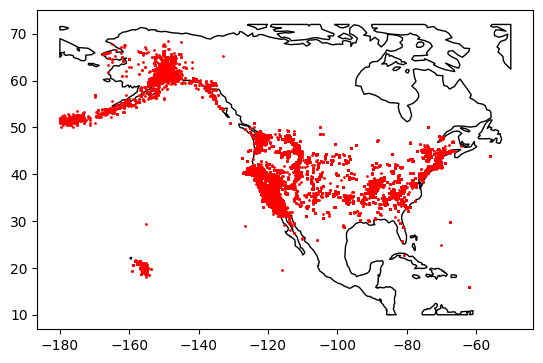

In [ ]:
world = geopandas.read_file(get_path("naturalearth.land"))

# We restrict to South America.
ax = world.clip([-200, 10, -50, 72]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=1)

plt.show()

## Deadly Hurricane Map

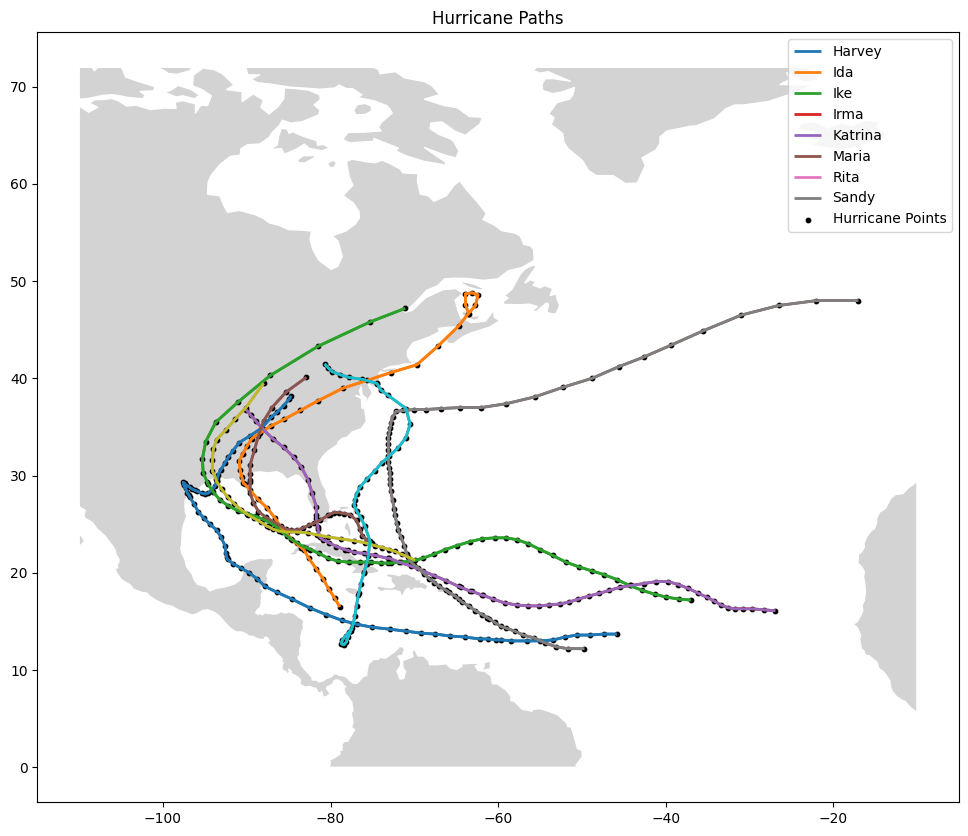

In [ ]:


hurricane_storms = matching_hurricanes['name'].unique() 

# Filter the dataset to include only those storms
matching_hurricanes = matching_hurricanes[matching_hurricanes['name'].isin(hurricane_storms)] # take only names that turnned into a hurricane

from shapely.geometry import Point, LineString
# Step 2: Create a GeoDataFrame
# Create a geometry column with Point objects
matching_hurricanes['geometry'] = matching_hurricanes.apply(lambda row: Point(row['long'], row['lat']), axis=1)
gdf = geopandas.GeoDataFrame(matching_hurricanes, geometry='geometry', crs='EPSG:4326')

# Step 3: Group by hurricane name and create paths
# Create a new GeoDataFrame for paths
paths = []
colors = plt.cm.tab10.colors  # Use a colormap for distinct colors
color_map = {}  # Dictionary to store color for each hurricane name

for i, (name, group) in enumerate(gdf.groupby('name')):
    # Ensure the group is sorted by time (year, month, day, hour)
    group = group.sort_values(by=['year', 'month', 'day', 'hour'])
    
    # Create a LineString for the hurricane path
    path_line = LineString(group.geometry.tolist())
    
    # Add the LineString as a new row in the paths list
    paths.append({'name': name, 'geometry': path_line})
    color_map[name] = colors[i % len(colors)]  # Cycle through colors

# Convert the paths list into a GeoDataFrame
paths_gdf = geopandas.GeoDataFrame(paths, crs='EPSG:4326')

# Step 4: Plot the map
# Create a base map
world = geopandas.read_file(get_path("naturalearth.land"))
ax = world.clip([-110, 0, -10, 72]).plot(color='lightgrey', edgecolor='white', figsize=(12, 10))

# Plot each hurricane's path with a unique color
for name, color in color_map.items():
    paths_gdf[paths_gdf['name'] == name].plot(ax=ax, color=color, linewidth=2, label=name)

# Plot each hurricane's path with a unique color
paths_gdf.plot(ax=ax, column='name', legend=True, cmap='tab10', linewidth=2)
gdf.plot(ax=ax, color='black', markersize=10, label="Hurricane Points")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Hurricanes", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Hurricane Paths")
plt.legend()
plt.show()